# Home Assignment -- 2

Please, write your solutions within the designated blocks:
```python
...
### BEGIN Solution

# >>> your solution here <<<

### END Solution
...
```

Import visualization and data processing libraries

In [106]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

<br/> <!--Intentionally left blank-->

# Part 1 (33 pt.): Convex Programs and Support Vector Models

In this **first two tasks** of this part of the homework you will implement
your own Support Vectors Regression and then test on a simple real dataset.

In the last task you are asked to solve a simple small NLP problem using
support vector classfiers from [scikit-learn](http://scikit-learn.org/stable/modules/svm.html#classification).
If you successfully complete the task, it will give you a ready-to-use and
straighforward baseline for any NLP classification task of moderate size.

### Support Vector Regression

$$\frac{1}{2}\|w\|^2 + C\sum_{i=1}^l(\xi_i + \xi_i') \to \min_{w, b, \xi_i, \xi_i'}\\
(w^Tx_i + b) - y_i \leq \epsilon - \xi_i\\
y_i - (w^Tx_i + b) \leq \epsilon - \xi_i'\\
\xi_i \geq 0\\
\xi_i' \geq 0$$

This problem can be written as empirical risk minimization problem with regularization

#### Equivalent
$$ \frac{1}{2}\|w\|^2 + C\sum_{i=1}^l h(\hat{y}_i, y_i)$$



Where
$$ h(\hat{y}_i, y_i) = \max(0, |\hat{y} - y| - \epsilon ) $$
is the $\epsilon$-insensitive loss, and
$$ \hat{y}_i = (w, x_i) + b $$
is the prediction.

For our experiments we will use "Cars" dataset, which contains information about braking distances for several cars from the 1920s.

In [74]:
cars_info = pd.read_csv('data/cars.csv', index_col=0, dtype=np.float)

X = cars_info.speed.values.reshape(-1, 1)

Normalization leads to better convergence

In [75]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()

X_train = X_scaler.fit_transform(X)
y_train = cars_info.dist

Text(0,0.5,'Distance')

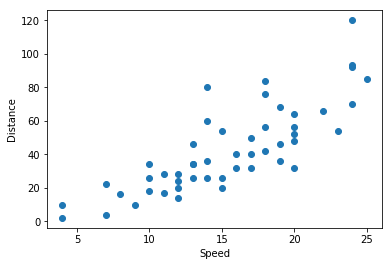

In [76]:
ax = plt.gca()
ax.plot(X, y_train, 'o')
ax.set_xlabel('Speed')
ax.set_ylabel('Distance')

<br/> <!--Intentionally left blank-->

## Task 1 (11 pt.)

Please implement a function that calculates the current loss value and its gradient
at the specified values of weights $w$, bias $b$, selected $C$ and $\epsilon$.

In [77]:
def calculate_eps_insensetive_loss(X, y, w, b, C=1.0, eps=0.1):
    '''Calculate hinge loss function
    :param: X -- numpy array of shape l x n
    :param: y -- numpy array of shape l with values 1 and -1
    :param: w -- numpy array of shape n
    :param: b -- np.float64
    :param: C -- np.float64 
    '''
    # Calculate Loss
    loss = 0
    ### BEGIN Solution
    n = X.shape[0]
    elementwise_module = X @ w + b - y
    elementwise_h = np.absolute(elementwise_module) - eps
    elementwise_risk = np.maximum(0,elementwise_h)
    loss = C * np.sum(elementwise_risk) + 0.5 * np.sum(w * w)
    ### END Solution

    # Calculate Gradient for hinge loss    
    w_grad = np.zeros_like(w)
    b_grad = 0
    ### BEGIN Solution
    h_indices = np.nonzero(elementwise_h>0)[0]
    module_indices = np.nonzero(elementwise_module>0)[0]
    pos_indices = np.intersect1d(h_indices, module_indices)
    neg_indices = np.setdiff1d(h_indices, module_indices)
    
    w_grad = C * (X[pos_indices,:].sum(axis = 0) - X[neg_indices,:].sum(axis = 0)) + w
    b_grad = C *(pos_indices.shape[0] - neg_indices.shape[0])
    ### END Solution

    return loss, w_grad, b_grad

Following code finds optimal values for your loss function with simple constant step gradient descend.

In [78]:
# Model's metaparameters
eps = 0.1
C = 100

# Gradient descent parameters
step = 1e-4
tolerance = 1e-3

# Optimization logging
converged = False
index = 0
training_loss_history = []
training_loss_iteration = []

# Parameters initialization
w = np.zeros(1)
b = 0
loss, w_grad, b_grad = calculate_eps_insensetive_loss(X_train, y_train, w, b, C, eps)

while not converged:
    # Update parameters
    new_w = w - step * w_grad
    new_b = b - step * b_grad
    # Calculate new loss and gradient
    new_loss, w_grad, b_grad = calculate_eps_insensetive_loss(X_train, 
                                                    y_train, 
                                                    new_w, new_b, C, eps)
    # Check convergence
    if np.abs(loss - new_loss) < tolerance:
        converged = True
    
    b, w, loss = new_b, new_w, new_loss
    
    # Update history
    index += 1
    if index % 10 == 0:
        training_loss_history.append(new_loss)
        training_loss_iteration.append(index)

Text(0,0.5,'Loss value')

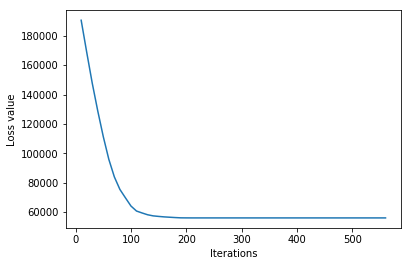

In [79]:
axis = plt.gca()
axis.plot(training_loss_iteration, training_loss_history)
axis.set_xlabel('Iterations')
axis.set_ylabel('Loss value')

We are going calculate predictions for all speeds in range from $0$ to $30$.

In [80]:
x_grid = np.arange(0., 30., 1).reshape(-1, 1)
x_test = X_scaler.transform(x_grid)

In [81]:
predictions = x_test @ w + b

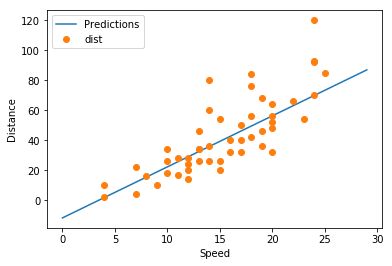

In [82]:
ax = plt.gca()
ax.plot(x_grid, predictions, label='Predictions')
ax.plot(X, y_train, 'o')
ax.set_xlabel('Speed')
ax.set_ylabel('Distance')
ax.legend(loc='best')

<br/> <!--Intentionally left blank-->

## Task 2 (11 pt.)

In this task the goal is to implement the SVR algorithm based on its dual problem version.

### SVR Dual Problem

\begin{equation}
    \begin{aligned}
        & \underset{\alpha', \alpha}{\text{minimize}}
          & & \frac{1}{2}(\alpha' - \alpha)^T  K (\alpha' - \alpha)
              - (\alpha' - \alpha)^T Y
              + \epsilon (\alpha' + \alpha)^T \mathbf{1}
              \,, \\
        & \text{subject to}
          & & (\alpha' - \alpha)^T \mathbf{1} = 0
              \,, \\
        & & & \alpha', \alpha \in [0, C]
              \,.
    \end{aligned}
\end{equation}

### Quadtratic Optimization Problem

\begin{equation}
    \begin{aligned}
        & \underset{x}{\text{minimize}}
          & & \tfrac12 x^T P x + q^T x
              \,, \\
        & \text{subject to}
          & & G x \leq h
              \,, \\
        & & & Ax = b
              \,.
    \end{aligned}
\end{equation}

Please notice that instead of just $\alpha$, like in the classification case, we have
two vectors of coefficients: $\alpha$ and $\alpha'$. As an input space consider using
stacked column vectors
\begin{equation}
    \begin{pmatrix}
        \alpha \\
        \alpha'
    \end{pmatrix}\,.
\end{equation}

**Hint**: You may find function `np.block` very usefull in this task

Now we are going to use **cvxopt** library, which has solvers for different kind
of convex optimization problems. Please notice that installation in Windows can
be a little tricky and painful.

http://cvxopt.org/

For more information about different types of optimization problem you can check
this presentations. This material could be very helpful, however is not necessary
for understatnding this course in Machine Learning.

http://ee364a.stanford.edu/lectures/problems.pdf

### Reformulate the Dual Problem

In [83]:
from cvxopt import matrix


def formulate_problem(X, y, kernel, C, epsilon):
    """Formulate quadratic optimization
    problem by defining matrices
    :param: X np.array of size n_elem * n_dim with reaining values
    :param: y np.array of size n_elem with labels 1 and -1
    :kernel: kernel function wich accepts two matrices of objects
    """
    quadratic_problem = {}

    # REMEMBER: all values should be wrapped in `cvxopt.matrix`
    # datatype (you can just use matrix(a) where a is `np.array`).
    # Please be careful cvxopt accepts only FLOAT not INTEGER data

    ### BEGIN Solution
    n = X.shape[0]
    I = np.eye(n)
    R = np.block([-I,I])
    M = np.block([I,I])
    K = kernel(X, X)
    one = np.ones((n,1))
    quadratic_problem['P'] = matrix(R.T @ K @ R)
    quadratic_problem['q'] = matrix( (-1 * y.T @ R + epsilon * one.T @ M).reshape(2*n,1))

    quadratic_problem['G'] = matrix(np.block([[np.eye(2*n)],[-1*np.eye(2*n)]]))
    quadratic_problem['h'] = matrix(np.hstack((np.array(np.repeat(C,2*n), dtype = np.float64), np.zeros(2*n))))

    quadratic_problem['A'] = matrix(one.T @ R)
    quadratic_problem['b'] = matrix(0.0)

    ### END Solution

    return quadratic_problem

### Check the Results

The module **metrics.pairwise** in **sklearn** has a very fast and well documented
implementation of kernel matrix calculator. We fix the width of the RBF kernel at
$1.0$ for simplicity.

In [84]:
from sklearn.metrics.pairwise import rbf_kernel
from functools import partial

# the width of the RBF kernel is 1.0
kernel = partial(rbf_kernel, gamma=0.1)

**cvxopt** has powerful and versatile solvers for almost every convex
optimization problem: linear, conic, and **quadratic**. We are using
the latter.

In [85]:
# Optimization routine
from cvxopt.solvers import qp

qudratic_problem = formulate_problem(X_train, y_train.astype(float), kernel, C, eps)

results = qp(**qudratic_problem)

     pcost       dcost       gap    pres   dres
 0: -1.2634e+04 -2.4630e+05  2e+05  1e-13  5e-15
 1: -3.6309e+04 -7.2365e+04  4e+04  3e-13  6e-15
 2: -5.2798e+04 -5.9730e+04  7e+03  5e-13  6e-15
 3: -5.5424e+04 -5.7411e+04  2e+03  3e-13  6e-15
 4: -5.6356e+04 -5.6677e+04  3e+02  2e-16  7e-15
 5: -5.6510e+04 -5.6553e+04  4e+01  2e-13  6e-15
 6: -5.6532e+04 -5.6534e+04  2e+00  2e-13  8e-15
 7: -5.6533e+04 -5.6533e+04  3e-02  4e-13  7e-15
Optimal solution found.


Extract optimal point form the results and force **small values** of the coefficients to **zero**.

In [86]:
optimal_stacked_alpha = np.array(results['x']).ravel()

zero_threshold = 1e-6
### BEGIN Solution
# force negligible values to be exactly zero
optimal_stacked_alpha[np.absolute(optimal_stacked_alpha) < zero_threshold] = 0.0
### END Solution

### Prediction

Having a kernel function $K$ and optimal $(\alpha, \alpha')$, implement a function
that computes the dot product $(w \cdot x_i)$:

$$(w \cdot x_{test}) = \sum_{i=1}^l(\alpha_i' - \alpha_i)K(x_i, x_{test}) \,. $$

In [87]:
def kernel_dot_product(X_train, y_train, X_test, kernel, alpha):
    '''Calculate scalar product with vector w
    based on support vectors and dual coefficients
    :param: X_train np.array with train data
    :param: y_train np.array with train labels
    :param: X_test np.array with test data
    :parma: kernel the kernel function
    :param: alpha stacked dual coefficients
    '''
    output = np.zeros(len(X_test))

    ### BEGIN Solution
    n = X_train.shape[0]
    I = np.eye(n)
    R = np.block([-I,I])
    K_train_test = kernel(X_train, X_test)
    output[:] = alpha[np.newaxis, :] @ R.T @ K_train_test[:]
    ### END Solution

    return output

### Constant Calculation

The optimal constant $b$ can be derived from the theoretical properties of
the support vectors:
$$ b = y_i + \epsilon - (w \cdot x_i) \, \text{ if }\, 0 < \alpha_i < C \,, $$
and
$$ b = y_i - \epsilon - (w \cdot x_i) \, \text{ if }\, 0 < \alpha_i' < C \,. $$

For example, on infinitely powerful hardware with infinite precision arithmetic
you could have used any single support vector to get $b$. But it won't work IRL,
where the most you can hope for is [IEEE 754](https://en.wikipedia.org/wiki/IEEE_754)
quadruple precision [floating point numbers](https://en.wikipedia.org/wiki/Floating-point_arithmetic])
(setting aside special libraries or hardware). In the **numpy-scipy-sklearn** stack
on a typical x86-64 hardware your algorithms work in finite precision arithmetic, which
is subject to roundoff errors. The arithmetic results are pretty accurate, but still
**inexact**. Besides the numerical optimization algorithms (**cvxopt.qp**, **BFGS**,
**Your own SGD** and the like) themselves aren't exact, and produce just an **extremely
faithful** approximation of the optmial coefficients.

Your task here is to use as many support vectors as possible to get an estimate of $b$.

In [189]:
def calculate_bias(X_train, y_train, kernel, alpha, eps=0.1):
    """Calculates the bias 
    :param: X_train np.array with train data
    :param: y_train np.array with train labels
    :parma: kernel the kernel function
    :param: alpha stacked dual coefficients'''
    """
    b = 0.0

    ### BEGIN Solution
    n = X_train.shape[0]
    
    ind_1 = (alpha[:n]>0) & (alpha[:n]<C) 
    ind_2 = (alpha[n:]>0) & (alpha[n:]<C)
    b_1 = y_train[ind_1] + eps - kernel_dot_product(X_train, y_train, X[ind_1], kernel, alpha)
    b_2 = y_train[ind_2] - eps - kernel_dot_product(X_train, y_train, X[ind_2], kernel, alpha)
    
    b = np.hstack([b_1,b_2]).mean()
    print (np.mean(b))
    ### END Solution

    return b

In [190]:
b = calculate_bias(X_train, y_train, kernel, optimal_stacked_alpha, eps)

40.77966201996926


Now we use the optimal $b$ and $\alpha, \alpha'$ to get the predictions and finally plot
a nice picture of the SVR.

In [193]:
predictions = kernel_dot_product(X_train, y_train, x_test, kernel, optimal_stacked_alpha) + b
print (predictions)

[ 0.60860442  0.52423448  0.74042193  1.25522713  2.06327801  3.15688436
  4.52720392  6.16534377  8.06328051 10.21449343 12.6142269  15.25932952
 18.14765613 21.2770611  24.6440535  28.24222289 32.06057429 36.08192939
 40.28155626 44.62617968 49.07350056 53.57231629 58.0632881  62.48035025
 66.7527037  70.80728883 74.57159153 77.97660845 80.95978298 83.46772397]


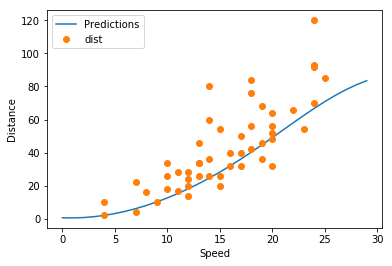

In [192]:
ax = plt.gca()
ax.plot(x_grid, predictions, label='Predictions')
ax.plot(X, y_train, 'o')
ax.set_xlabel('Speed')
ax.set_ylabel('Distance')
ax.legend(loc='best')

<br/> <!--Intentionally left blank-->

## Task 3 (11 pt.)

In this task we are going to use SVM for text classification. We will work with
dataset which  contains different tweets with the related conversation context.
Some of the tweets are generated by bots, others -- written by humans.

In [374]:
train_data = pd.read_csv('data/bot_or_not_train_clean.txt', sep='\t', index_col=0)

test_data = pd.read_csv('data/bot_or_not_test.txt', sep='\t', index_col=0)

In [375]:
train_data.head()

,context,response,human-generated
id,,,
0,<first_speaker> 95 degrees with <number> % hum...,<second_speaker> <at> i forgot that thanksabit...,0
1,<first_speaker> <at> <at> yar ! oy just appear...,<first_speaker> <at> lol b we 'll see . we hea...,0
2,<first_speaker> ohh ! deu certo ! ! dddddddddd...,"<second_speaker> <at> acordei agora , qqqqq ? ...",1
3,<first_speaker> ughhhh i wanted a pickle . non...,<second_speaker> <at> lol gm,0
4,<first_speaker> <at> <at> <at> need to know to...,"<first_speaker> <at> ok , will do - don 't be ...",1


Please notice that context and response columns contains raw text, which is not
directly suitable for machine learning.

### Task 3.1 (6 pt.)

To extract features we are going to use the **bag of words** techniques. Please read
the documentation for `CountVectorizer` [in scikit](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
and do the following:

* For both the context and the response generate a set of features using
two separate count vectorizers.

* Join this sets of features into one feature matrix (please notice that
`CountVectorizer` returns Scipy [CSR sparse matrices](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)).

* Pick the optimal $C$ for the **linear kernel** using cross valudation
`GridSearchCV` and `ROC AUC` as the target metric.

* Choose the optimal `gamma` and $C$ for the RBF kernel using cross valudation
`GridSearchCV` targeting `ROC AUC` metric.

* Take the **best models** with linear and RBF kernels, plot **their ROC curves**
on the provided heldout test data on the same figure, and print their `ROC AUC`
score. Which models work better on the test dataset?

In [376]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Generate feature matricies for the context and the response. Fill free to create additional
feature extraction objects if you like.

In [377]:
y_train = train_data['human-generated']

### BEGIN Solution
vectorizer_1 = CountVectorizer(lowercase=False)
x_context = vectorizer_1.fit_transform(train_data['context'])

vectorizer_2 = CountVectorizer(lowercase=False)
x_response = vectorizer_2.fit_transform(train_data['response'])

# Join the feature matrix
x_train = sparse.hstack([x_context, x_response])

### END Solution

Generate the response and contet test sets with their **relevant** feature encodings.

In [378]:
y_test = test_data['human-generated']

### BEGIN Solution
x_context_test = vectorizer_1.transform(test_data['context'])

x_response_test = vectorizer_2.transform(test_data['response'])

x_test = sparse.hstack([x_context_test, x_response_test])
### END Solution

Select the best linear model among $C \in [\mathtt{1.e-3}, .., \mathtt{1.e3}]$.

In [332]:
### BEGIN Solution
# pick the best C

parameters = {'C':np.linspace(1e-3, 1e3,30)}
clf = GridSearchCV(SVC(kernel='linear', random_state= 42), parameters, scoring='roc_auc' ,verbose = 2,  n_jobs = -1)
clf.fit(x_train, y_train)
best_linear_model = clf.best_estimator_

### END Solution

Select the best RBF kernel model among the hyperparameters
$C \in [\mathtt{1.e-3}, .., \mathtt{1.e3}]$ and $\gamma \in [\mathtt{1.e-3}, .., \mathtt{1.e3}]$.

In [380]:
### BEGIN Solution
# pick the best C and gamma

parameters_2 = {'C':np.linspace(1e-3, 1e3,5, endpoint=True), 'gamma':np.linspace(1e-3, 1e3,5, endpoint=True)}
clf_2= GridSearchCV(SVC(kernel='rbf', random_state= 42), parameters_2, scoring='roc_auc' ,verbose = 2,  n_jobs = 4)
clf_2.fit(x_train, y_train)
best_kernel_model = clf_2.best_estimator_

### END Solution

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.001, gamma=0.001 ............................................
[CV] C=0.001, gamma=0.001 ............................................
[CV] C=0.001, gamma=0.001 ............................................
[CV] C=0.001, gamma=250.00075 ........................................
[CV] ......................... C=0.001, gamma=250.00075, total=  41.6s
[CV] C=0.001, gamma=250.00075 ........................................
[CV] ............................. C=0.001, gamma=0.001, total=  43.7s
[CV] C=0.001, gamma=250.00075 ........................................
[CV] ............................. C=0.001, gamma=0.001, total=  44.3s
[CV] C=0.001, gamma=500.0005 .........................................
[CV] ............................. C=0.001, gamma=0.001, total=  44.7s
[CV] C=0.001, gamma=500.0005 .........................................
[CV] ......................... C=0.001, gamma=250.00075, total=  43.5s
[CV] C=0.001, ga

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 10.6min


[CV] ...................... C=500.0005, gamma=250.00075, total=  41.3s
[CV] C=500.0005, gamma=500.0005 ......................................
[CV] ...................... C=500.0005, gamma=250.00075, total=  41.9s
[CV] C=500.0005, gamma=500.0005 ......................................
[CV] ...................... C=500.0005, gamma=250.00075, total=  43.9s
[CV] C=500.0005, gamma=750.00025 .....................................
[CV] ....................... C=500.0005, gamma=500.0005, total=  42.4s
[CV] C=500.0005, gamma=750.00025 .....................................
[CV] ....................... C=500.0005, gamma=500.0005, total=  41.6s
[CV] C=500.0005, gamma=750.00025 .....................................
[CV] ....................... C=500.0005, gamma=500.0005, total=  42.9s
[CV] C=500.0005, gamma=1000.0 ........................................
[CV] ...................... C=500.0005, gamma=750.00025, total=  43.7s
[CV] C=500.0005, gamma=1000.0 ........................................
[CV] .

[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed: 22.8min finished


Plot the `ROC` curves of both models and their `ROC AUC` scores.

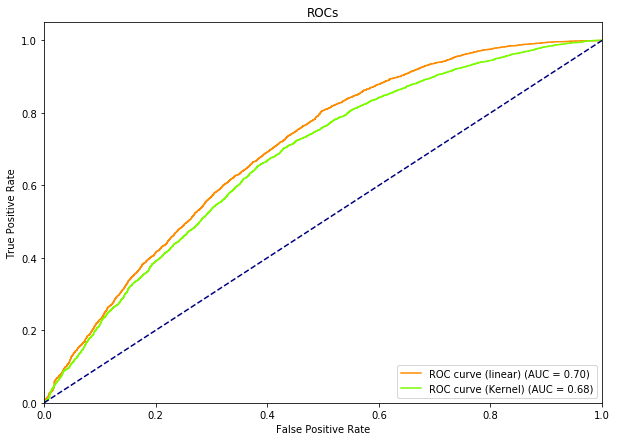

In [405]:
from sklearn.metrics import roc_curve
### BEGIN Solution
predictions_lin = best_linear_model.decision_function(x_train)
predictions_rbf = best_kernel_model.decision_function(x_train)
fpr_lin, tpr_lin, _ = roc_curve(y_train, predictions_lin)
fpr_rbf, tpr_rbf, _ = roc_curve(y_train, predictions_rbf)
auc_lin = roc_auc_score(y_train, predictions_lin)
auc_rbf = roc_auc_score(y_train, predictions_rbf)

plt.figure(figsize = (10,7))
plt.plot(fpr_lin, tpr_lin, color='darkorange', label='ROC curve (linear) (AUC = %0.2f)' % auc_lin)
plt.plot(fpr_rbf, tpr_rbf, color='lawngreen', label='ROC curve (Kernel) (AUC = %0.2f)' % auc_rbf)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROCs')
plt.legend(loc="lower right")
plt.show()
### END Solution

... and the best model is...?

In [406]:
best_model = best_linear_model
test_predictions = best_model.decision_function(x_test)
test_score = roc_auc_score(y_test, test_predictions)
print("Test ROC AUC = {}".format(test_score))

Test ROC AUC = 0.6441277961315569


### Task 3.2 (5 pt.)

Now you are asked to **redo the last task (3.1)**, bit this time with more advanced
features generated by [TfidfVectorizer](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).
To do this you can use `TfidfVectorizer` from sklearn.


In [407]:
from sklearn.feature_extraction.text import TfidfVectorizer

Generate feature matricies for context and response. Fill free to create
additional feature extraction object if necessary.

In [414]:
### BEGIN Solution
vectorizer_1_tf = TfidfVectorizer(lowercase=False)
x_context = vectorizer_1_tf.fit_transform(train_data['context'])

vectorizer_2_tf = TfidfVectorizer(lowercase=False)
x_response = vectorizer_2_tf.fit_transform(train_data['response'])

# Join the feature matrix
x_train = sparse.hstack([x_context, x_response])
### END Solution

Generate the response and contet test sets with their **relevant** feature encodings.

In [415]:
### BEGIN Solution
y_test = test_data['human-generated']

### BEGIN Solution
x_context_test = vectorizer_1_tf.transform(test_data['context'])

x_response_test = vectorizer_2_tf.transform(test_data['response'])

x_test = sparse.hstack([x_context_test, x_response_test])
### END Solution

Select the best linear model among $C \in [\mathtt{1.e-3}, .., \mathtt{1.e3}]$.

In [416]:
### BEGIN Solution
# pick the best C

parameters_3 = {'C':np.linspace(1e-3, 1e3,30)}
clf_3 = GridSearchCV(SVC(kernel='linear', random_state= 42), parameters_3, scoring='roc_auc' ,verbose = 2,  n_jobs = -1)
clf_3.fit(x_train, y_train)
best_linear_model = clf_3.best_estimator_

### END Solution

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] C=0.001 .........................................................
[CV] C=0.001 .........................................................
[CV] C=0.001 .........................................................
[CV] C=34.483724137931034 ............................................
[CV] .......................................... C=0.001, total=  40.1s
[CV] C=34.483724137931034 ............................................
[CV] .......................................... C=0.001, total=  40.3s
[CV] C=34.483724137931034 ............................................
[CV] ............................. C=34.483724137931034, total=  45.0s
[CV] C=68.96644827586208 .............................................
[CV] .......................................... C=0.001, total=  41.0s
[CV] C=68.96644827586208 .............................................
[CV] .............................. C=68.96644827586208, total=  40.0s
[CV] C=68.966448

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.4min


[CV] ............................. C=379.31096551724136, total=  43.6s
[CV] C=413.79368965517244 ............................................
[CV] ............................. C=379.31096551724136, total=  39.0s
[CV] C=413.79368965517244 ............................................
[CV] ............................. C=379.31096551724136, total=  39.6s
[CV] C=448.2764137931035 .............................................
[CV] ............................. C=413.79368965517244, total=  38.4s
[CV] C=448.2764137931035 .............................................
[CV] ............................. C=413.79368965517244, total=  44.0s
[CV] C=448.2764137931035 .............................................
[CV] ............................. C=413.79368965517244, total=  39.3s
[CV] C=482.7591379310345 .............................................
[CV] .............................. C=448.2764137931035, total=  44.0s
[CV] C=482.7591379310345 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 23.9min finished


Select the best RBF kernel model among the hyperparameters
$C \in [\mathtt{1.e-3}, .., \mathtt{1.e3}]$ and $\gamma \in [\mathtt{1.e-3}, .., \mathtt{1.e3}]$.

In [417]:
### BEGIN Solution
# pick the best C and gamma

parameters_4 = {'C':np.linspace(1e-3, 1e3,5, endpoint=True), 'gamma':np.linspace(1e-3, 1e3,5, endpoint=True)}
clf_4= GridSearchCV(SVC(kernel='rbf', random_state= 42), parameters_4, scoring='roc_auc' ,verbose = 2,  n_jobs = -1)
clf_4.fit(x_train, y_train)
best_kernel_model = clf_4.best_estimator_

### END Solution

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.001, gamma=0.001 ............................................
[CV] C=0.001, gamma=0.001 ............................................
[CV] C=0.001, gamma=0.001 ............................................
[CV] C=0.001, gamma=250.00075 ........................................
[CV] ............................. C=0.001, gamma=0.001, total=  44.6s
[CV] C=0.001, gamma=250.00075 ........................................
[CV] ......................... C=0.001, gamma=250.00075, total=  43.0s
[CV] C=0.001, gamma=250.00075 ........................................
[CV] ............................. C=0.001, gamma=0.001, total=  45.6s
[CV] C=0.001, gamma=500.0005 .........................................
[CV] ............................. C=0.001, gamma=0.001, total=  45.7s
[CV] C=0.001, gamma=500.0005 .........................................
[CV] ......................... C=0.001, gamma=250.00075, total=  41.8s
[CV] C=0.001, ga

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.2min


[CV] ...................... C=500.0005, gamma=250.00075, total=  41.7s
[CV] C=500.0005, gamma=500.0005 ......................................
[CV] ...................... C=500.0005, gamma=250.00075, total=  41.9s
[CV] C=500.0005, gamma=500.0005 ......................................
[CV] ...................... C=500.0005, gamma=250.00075, total=  42.5s
[CV] C=500.0005, gamma=750.00025 .....................................
[CV] ....................... C=500.0005, gamma=500.0005, total=  41.3s
[CV] C=500.0005, gamma=750.00025 .....................................
[CV] ....................... C=500.0005, gamma=500.0005, total=  41.9s
[CV] C=500.0005, gamma=750.00025 .....................................
[CV] ....................... C=500.0005, gamma=500.0005, total=  42.1s
[CV] C=500.0005, gamma=1000.0 ........................................
[CV] ...................... C=500.0005, gamma=750.00025, total=  42.8s
[CV] C=500.0005, gamma=1000.0 ........................................
[CV] .

[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 22.3min finished


Plot the `ROC` curves of both models and their `ROC AUC` scores.

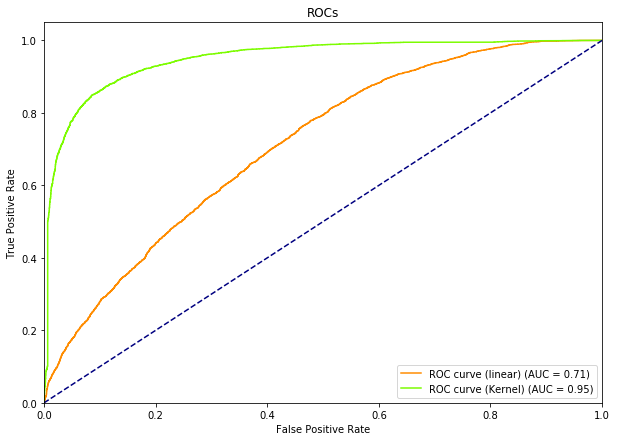

In [418]:
from sklearn.metrics import roc_curve
### BEGIN Solution
predictions_lin = best_linear_model.decision_function(x_train)
predictions_rbf = best_kernel_model.decision_function(x_train)
fpr_lin, tpr_lin, _ = roc_curve(y_train, predictions_lin)
fpr_rbf, tpr_rbf, _ = roc_curve(y_train, predictions_rbf)
auc_lin = roc_auc_score(y_train, predictions_lin)
auc_rbf = roc_auc_score(y_train, predictions_rbf)

plt.figure(figsize = (10,7))
plt.plot(fpr_lin, tpr_lin, color='darkorange', label='ROC curve (linear) (AUC = %0.2f)' % auc_lin)
plt.plot(fpr_rbf, tpr_rbf, color='lawngreen', label='ROC curve (Kernel) (AUC = %0.2f)' % auc_rbf)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROCs')
plt.legend(loc="lower right")
plt.show()
### END Solution

... and the best model is...?

In [419]:
best_model = best_kernel_model
test_predictions = best_model.decision_function(x_test)
test_score = roc_auc_score(y_test, test_predictions)
print("Test ROC AUC = {}".format(test_score))

Test ROC AUC = 0.6619753196477767


<br/> <!--Intentionally left blank-->